In [97]:
import math 
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [98]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self._prev = set(_children)
        self._op = _op
        self.label = label
        self.grad = 0.0
        self._backward = lambda: None

    def __repr__(self):
        return f"Value(data={self.data})"
    def __add__(self, other):

        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), "+")
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), "*")
        def _backward():
            self.grad += (other.data * out.grad)
            other.grad += (self.data * out.grad)
        out._backward = _backward
        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self,), "exp")

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward
        return out
    
    def __truediv__(self, other):
        return self * other**(-1)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supporting int/float powers for now"
        out = Value(self.data**other, (self,), f'**{other}')
        
        def _backward():
            self.grad += other * (self.data**(other-1)) * out.grad
        out._backward = _backward
        return out

    def __sub__(self, other):
        return self + (-other)

    def tanh(self):
        t = self.data
        x = (math.exp(2*t)-1)/(math.exp(2*t)+1)
        out = Value(x, (self,), "tanh")
        def _backward():
            self.grad += (1-x**2) * out.grad
        out._backward = _backward
        return out

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        topo
        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

    def __rmul__(self, other):
        return self * other

In [99]:
from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):  
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges
def draw_dot(root):
    dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
    
    nodes, edges = trace(root)
    for n in nodes: 
        uid = str(id(n))
        # for any value in the graph, create a rectangular ('record') node for it
        dot.node(name=uid, label="{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record') 
        if n._op:
            # if this value is a result of some operation, create an op node for it
            dot.node(name=uid + n._op, label=n._op)
            # and connect this node to it
            dot.edge(uid + n._op, uid)
    
    for n1, n2 in edges:
        # connect n1 to the op node of n2
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
        
    return dot

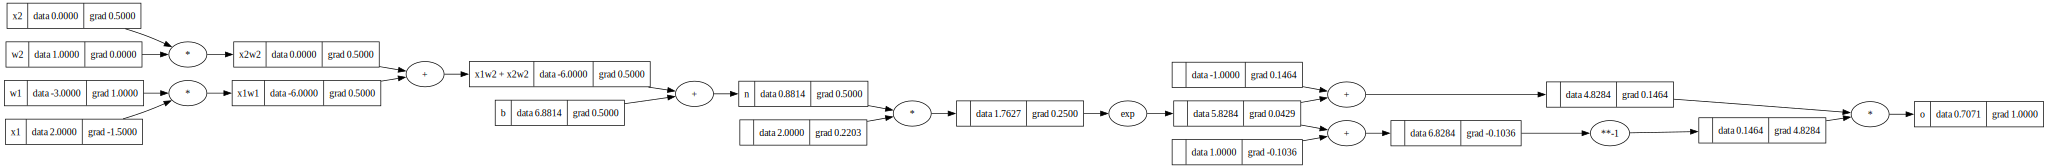

In [100]:
#neuron modeling test with two inputs

x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")  

#weights
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias
b = Value(6.881373587019543, label = "b")
x1w1 = x1*w1; x1w1.label = "x1w1"
x2w2 = x2*w2; x2w2.label = "x2w2"

#everything combined together
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w2 + x2w2"
n = x1w1x2w2 + b; n.label = "n"

e = (2*n).exp()
o = (e - 1) / (e + 1)

o.label = "o"

""" Manual Back Propagation
o.grad = 1.0
n.grad = (1-o.data**2)
x1w1x2w2.grad = n.grad
b.grad = n.grad
x1w1.grad = x1w1x2w2.grad
x2w2.grad = x1w1x2w2.grad
x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad
x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad
"""

""" Manually Calling Back Propagation
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x2w2._backward()
x1w1._backward()
"""
o.backward()
draw_dot(o)